# Historical vs. Current

Does a model trained on the old data work well on more recent data? This can tell us whether there is unnatural increase or decrease in recent baseflow. Specifically, model overestimation of recent baseflow data tells us that there may be a recent, human caused contributor to a decrease in baseflow.

In [32]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from datetime import datetime, timedelta

## Prepare Data
- Create "Date_Adjusted" column which adjusts dates to be from 1900
- Sort values in DataFrame by date

In [33]:
baseflow = pd.read_csv("RRCA_baseflow.csv")

def minusDate(x):
    return (x - 693963)

def getDateTime(x):
    start_date = datetime(1,1,1)
    return  start_date + timedelta(days=x)

def get_season(date):
    """
    Determine the season for a given date.
    """
    month = date.month
    if month in [12, 1, 2]:
        return "Winter"
    elif month in [3, 4, 5]:
        return "Spring"
    elif month in [6, 7, 8]:
        return "Summer"
    else:
        return "Autumn"
    
def get_year(date):
    return int(date.year)

baseflow['DateTimes'] = baseflow['Date'].apply(getDateTime)
baseflow['Season'] = baseflow['DateTimes'].apply(get_season)
baseflow['Year'] = baseflow['DateTimes'].apply(get_year)
baseflow['Date_Adjusted'] = baseflow['Date'].apply(minusDate)

baseflow.sort_values(by='Date_Adjusted',inplace=True)
baseflow = baseflow.reset_index()
del baseflow['index']
baseflow

,Date,Segment_id,x,y,Evapotranspiration,Precipitation,Irrigation_pumping,Observed,DateTimes,Season,Year,Date_Adjusted
0,708479,123,859150,14714400,1.98,14.60,0.00000,13.793443,1940-10-02,Autumn,1940,14516
1,708479,256,1941550,14524320,1.96,18.90,0.00000,13.524590,1940-10-02,Autumn,1940,14516
2,708479,194,970030,14571840,1.98,16.10,0.00000,27.272131,1940-10-02,Autumn,1940,14516
3,708479,189,1392430,14571840,0.00,0.00,0.00000,0.000000,1940-10-02,Autumn,1940,14516
4,708479,157,1022830,14672160,1.98,14.00,0.00000,70.885246,1940-10-02,Autumn,1940,14516
...,...,...,...,...,...,...,...,...,...,...,...,...
15586,730729,56,1170670,14582400,0.00,0.00,0.00000,3.289508,2001-09-02,Autumn,2001,36766
15587,730729,178,927790,14540160,5.02,15.65,-0.77655,-5.476229,2001-09-02,Autumn,2001,36766
15588,730729,152,1360750,14529600,5.02,22.02,-0.36817,0.355738,2001-09-02,Autumn,2001,36766
15589,730729,171,1508590,14524320,5.02,0.00,-0.23088,0.762295,2001-09-02,Autumn,2001,36766


In [34]:
# Pick particular area
areas = baseflow['Segment_id'].unique()
# areas = [96]
baseflowAreas = [baseflow[baseflow['Segment_id'] == id] for id in areas]
display(baseflowAreas)
print(len(baseflowAreas))
for df in baseflowAreas:
    if len(df) < 10:
        baseflowAreas.remove(df)
        print("Removing")
    print(len(df), end=', ')

[       Date  Segment_id       x         y  Evapotranspiration  Precipitation  \
 0    708479         123  859150  14714400                1.98           14.6   
 27   708509         123  859150  14714400                1.30           14.6   
 37   708540         123  859150  14714400                0.52           14.6   
 50   708571         123  859150  14714400                0.00           16.9   
 63   708600         123  859150  14714400                0.72           16.9   
 82   708631         123  859150  14714400                0.00           16.9   
 92   708661         123  859150  14714400                3.04           16.9   
 105  708692         123  859150  14714400                6.59           16.9   
 
      Irrigation_pumping   Observed  DateTimes  Season  Year  Date_Adjusted  
 0                   0.0  13.793443 1940-10-02  Autumn  1940          14516  
 27                  0.0  14.593443 1940-11-01  Autumn  1940          14546  
 37                  0.0  15.822581

42
Removing
8, 72, 718, 133, 108, 116, 456, 240, 119, 732, 342, 732, 706, 720, 708, 645, 693, 399, 123, 118, 656, 653, 482, 576, 102, 66, 393, 450, 324, 596, 257, 315, 489, 285, 89, 85, 495, 480, 459, 56, 276, 

## Partition into Training and Testing sets

In [35]:
cutoff = 1970
trainDataVector = [baseflowAreas[i][(baseflowAreas[i].Year < cutoff)] for i in range(len(baseflowAreas))]
testDataVector = [baseflowAreas[i][(baseflowAreas[i].Year >= cutoff)] for i in range(len(baseflowAreas))]


# feature_cols = ['x', 'y', 'Date_Adjusted', 'Evapotranspiration', 'Precipitation', 'Irrigation_pumping']
feature_cols = ['Date_Adjusted', 'Evapotranspiration', 'Precipitation', 'Irrigation_pumping']

trainXVector = []
trainYVector = []
testXVector = []
testYVector = []
for i in range(len(trainDataVector)):
    train = trainDataVector[i]
    test = testDataVector[i]
    if len(train) > 0 and len(test) > 0:
        trainXVector.append(train[feature_cols])
        trainYVector.append(train['Observed'])
        testXVector.append(test[feature_cols])
        testYVector.append(test['Observed'])
trainXVector

[      Date_Adjusted  Evapotranspiration  Precipitation  Irrigation_pumping
 3             14516                 0.0            0.0                 0.0
 24            14546                 0.0            0.0                 0.0
 38            14577                 0.0            0.0                 0.0
 45            14608                 0.0            0.0                 0.0
 61            14637                 0.0            0.0                 0.0
 ...             ...                 ...            ...                 ...
 7893          25048                 0.0            0.0                 0.0
 7903          25078                 0.0            0.0                 0.0
 7929          25109                 0.0            0.0                 0.0
 7967          25139                 0.0            0.0                 0.0
 7982          25170                 0.0            0.0                 0.0
 
 [351 rows x 4 columns],
       Date_Adjusted  Evapotranspiration  Precipitation  Irri

## Plot Distributions of Training and Testing Data

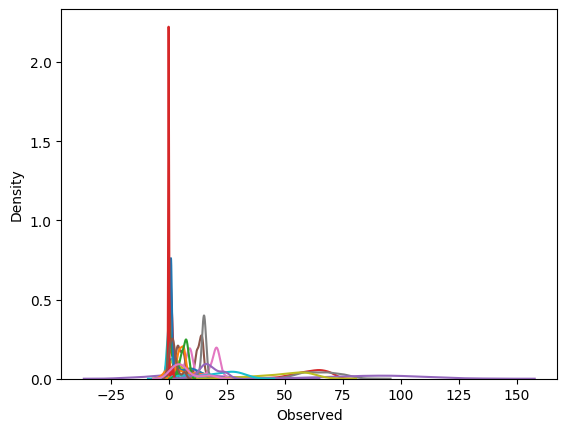

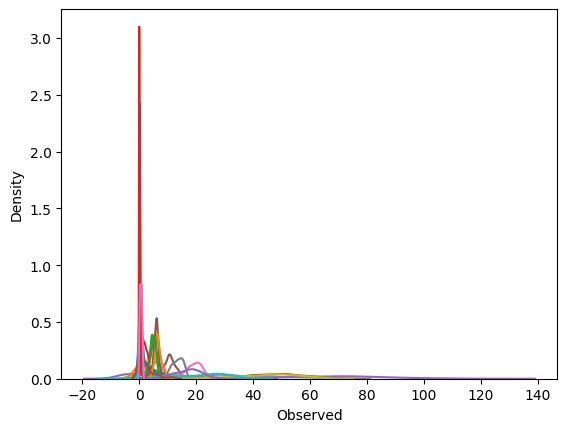

In [36]:
for data in trainYVector:
    sns.kdeplot(data)
plt.show()
for data in testYVector:
    sns.kdeplot(data)
plt.show()

## Define Linear Regression Model

In [37]:
models = [LinearRegression() for _ in trainXVector]
for i in range(len(trainXVector)):
    trainX = trainXVector[i]
    models[i].fit(trainX,trainYVector[i])

    # display(f"Intercept: {models[i].intercept_}")
    # display(f"Coefficients: {list(zip(feature_cols, models[i].coef_))}")

## Plot Predicted Results with Actual Results

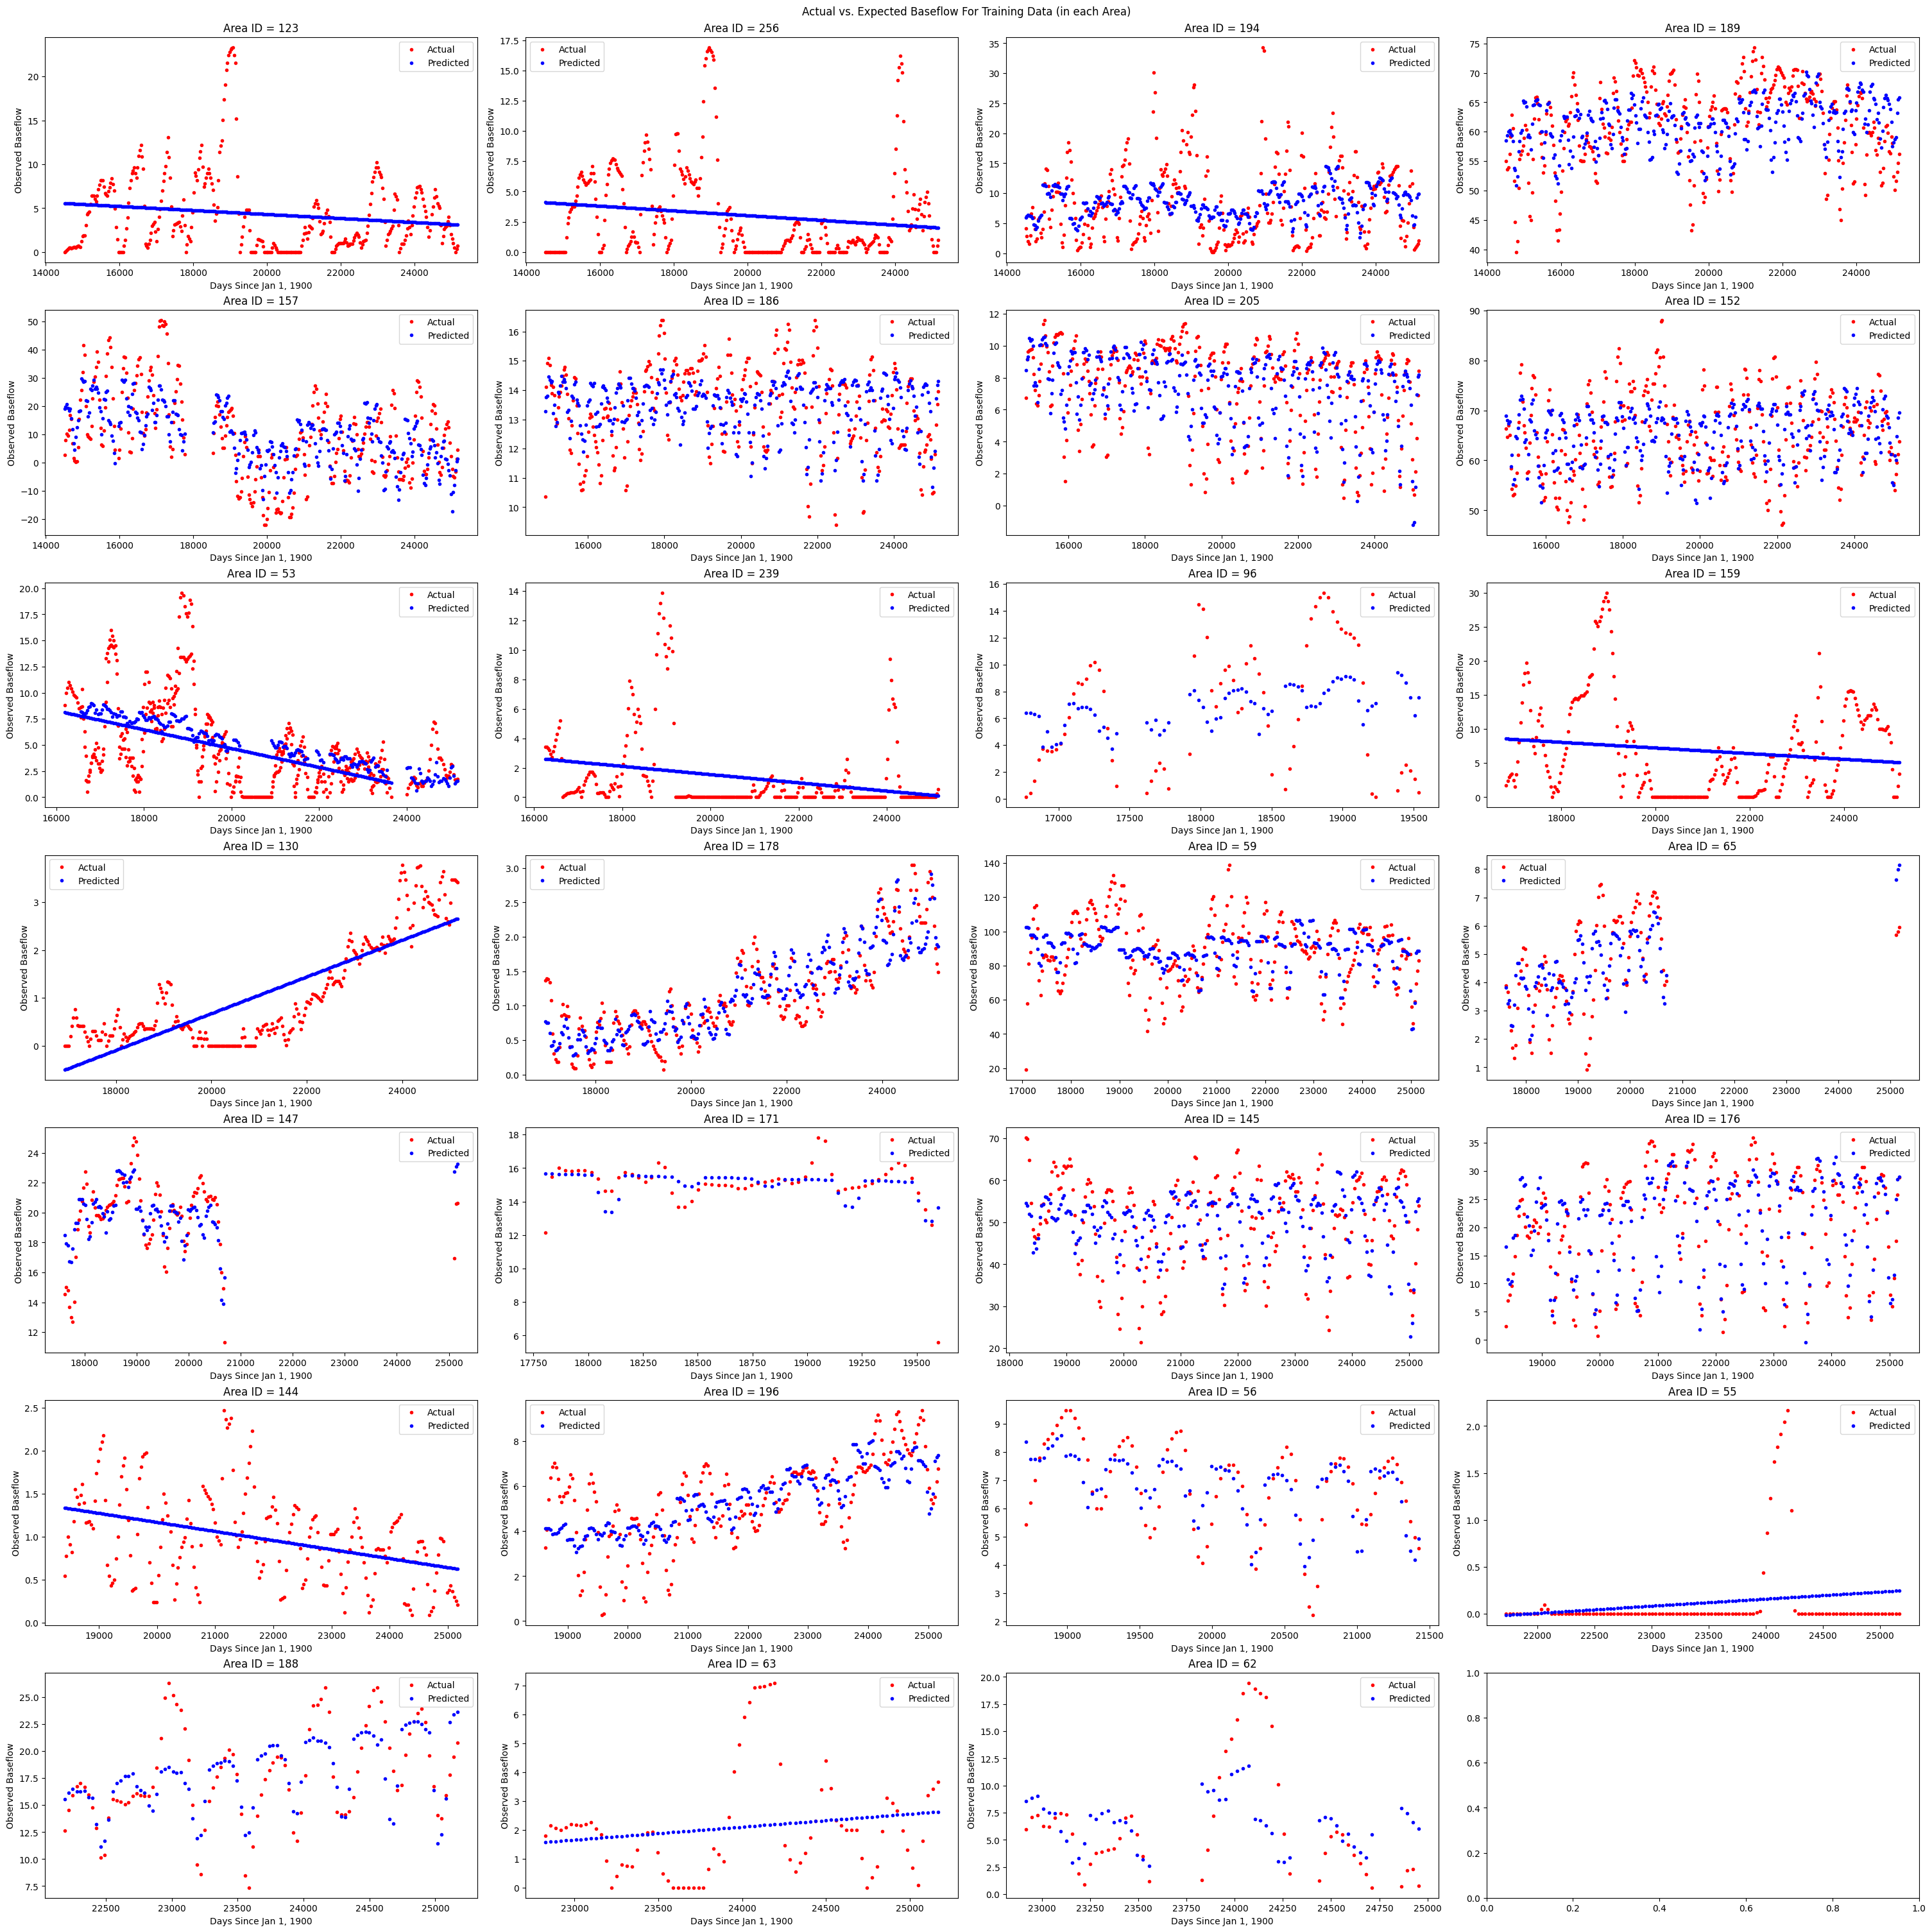

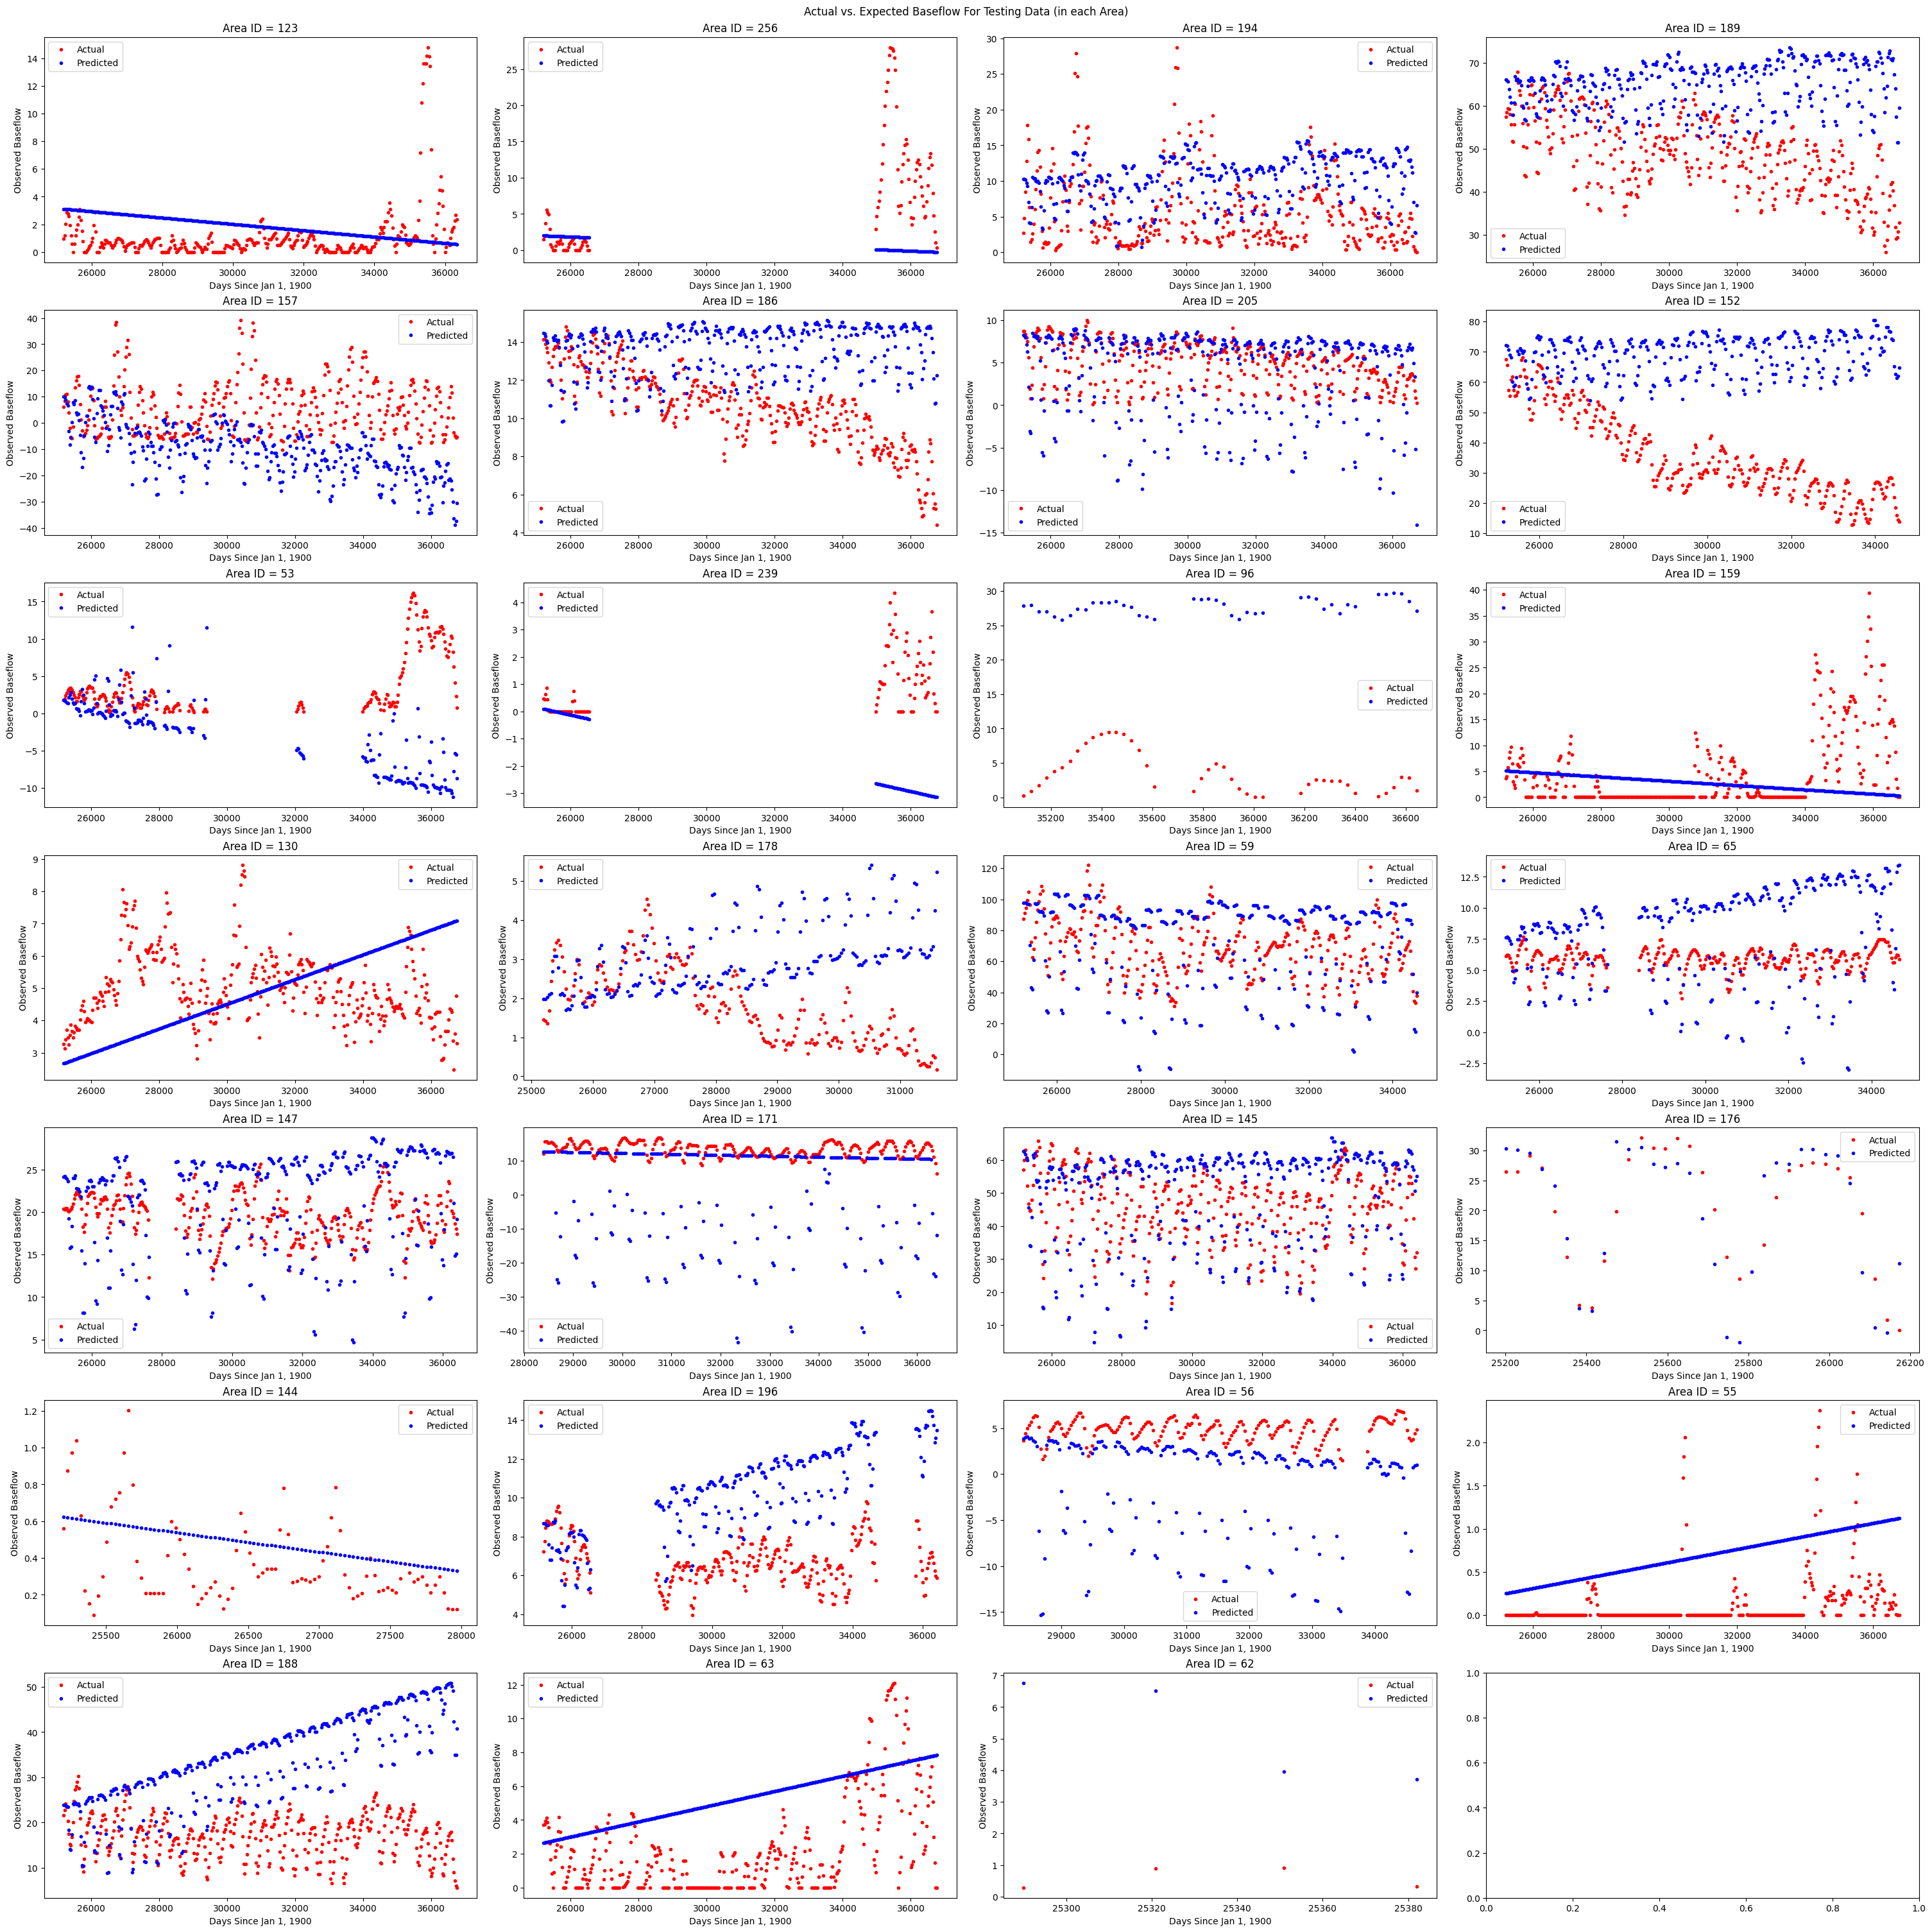

In [38]:
predictYVector = []
for i in range(len(testXVector)):
    predictYVector.append(models[i].predict(testXVector[i]))

figWidth = 4
figSize = (30,30)

# Plot actual vs. expected for training data
fig, ax = plt.subplots(len(testXVector)//figWidth+1,figWidth,figsize=figSize, layout='constrained')
for k in range(len(testXVector)):
    x_train = trainXVector[k]
    y_train = trainYVector[k]
    model = models[k]
    y_pred = model.predict(x_train)
    i = k // figWidth
    j = k - i * figWidth
    ax[i,j].plot(x_train['Date_Adjusted'], y_train.values,'.', color='red',label='Actual')
    ax[i,j].plot(x_train['Date_Adjusted'], y_pred, '.',color='blue', label='Predicted')
    ax[i,j].set_title(f"Area ID = {areas[k]}")
    ax[i,j].set_xlabel("Days Since Jan 1, 1900")
    ax[i,j].set_ylabel("Observed Baseflow")
    ax[i,j].legend()
plt.suptitle("Actual vs. Expected Baseflow For Training Data (in each Area)")
plt.show()

# Plot actual vs. expected for test data
fig, ax = plt.subplots(len(testXVector)//figWidth+1,figWidth,figsize=figSize, layout='constrained')
for k in range(len(testXVector)):
    x_test = testXVector[k]
    y_test = testYVector[k]
    y_pred = predictYVector[k]
    i = k // figWidth
    j = k - i * figWidth
    ax[i,j].plot(x_test['Date_Adjusted'], y_test.values,'.', color='red',label='Actual')
    ax[i,j].plot(x_test['Date_Adjusted'], y_pred, '.',color='blue', label='Predicted')
    ax[i,j].legend()
    ax[i,j].set_title(f"Area ID = {areas[k]}")
    ax[i,j].set_xlabel("Days Since Jan 1, 1900")
    ax[i,j].set_ylabel("Observed Baseflow")
plt.suptitle("Actual vs. Expected Baseflow For Testing Data (in each Area)")
plt.show()

# Does the Model Overestimate or Underestimate?

Take $y - \hat{y}$ for each point and divide by number of points. If this value is ~ 0, then the model is not consistently overestimating or underestimating. If the value is $< 0$, the model is consistently overestimating the baseflow. If the value is $> 0$, the model is consistently underestimating baseflow.

In [39]:
errorPerPointVector = [0 for _ in testYVector]
for i in range(len(testYVector)):
    predY = predictYVector[i]
    for j in range(len(predY)):
        errorPerPointVector[i] += testYVector[i].values[j] - predY[j]
    errorPerPointVector[i] /= len(predY)

areasWithError = list(zip(areas, errorPerPointVector))

positive = [(area, error) for (area, error) in areasWithError if error > 1]
neutral = [(area, error) for (area, error) in areasWithError if error > -1 and error < 1]
negative = [(area, error) for (area, error) in areasWithError if error < -1]
display("Underestimation (area, error)", positive)
display("Overestimation (area, error)", negative)
display("Neither (area, error)", neutral)


'Underestimation (area, error)'

[(256, 6.548571657048357),
 (157, 16.470586851192554),
 (53, 7.2860564473277485),
 (239, 2.550341025218094),
 (159, 1.7935066509358446),
 (171, 10.606300359632042),
 (56, 5.925649198802051)]

'Overestimation (area, error)'

[(194, -4.7896545852712435),
 (189, -16.531986539019393),
 (186, -3.0646731453254255),
 (152, -33.063694715967635),
 (96, -24.283205999795342),
 (178, -1.2007966414848488),
 (59, -6.3316023338859555),
 (65, -2.257830138915805),
 (147, -2.230317606777498),
 (145, -3.9730335578283653),
 (196, -3.716561081179332),
 (188, -16.682002900195776),
 (63, -3.0095531813204466),
 (62, -4.633711191205577)]

'Neither (area, error)'

[(123, -0.712389708841324),
 (205, 0.8146532021714946),
 (130, 0.12668266777801038),
 (176, 0.3292103096631023),
 (144, -0.10018034717169823),
 (55, -0.5658156575086065)]

A positive error per point implies that the actual baseflow is on average larger than the predicted baseflow. Although there is a downward trend in baseflow, the downward trend is not as drastic as predicted.

## Plot Each Area

Plot the x and y values of each area, and mark whether the model overestimated the baseflow, underestimated the baseflow, or neither.

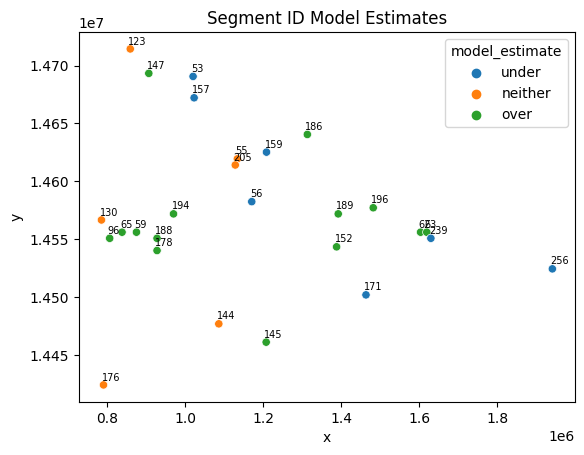

In [55]:
underestimateAreas = [area for (area, _) in positive]
overestimateAreas = [area for (area, _) in negative]
neutralAreas = [area for (area,_) in neutral]
model_estimate = []
for idx in baseflow.index:
    if baseflow['Segment_id'][idx] in overestimateAreas:
        model_estimate.append("over")
    elif baseflow['Segment_id'][idx] in underestimateAreas:
        model_estimate.append('under')
    elif baseflow['Segment_id'][idx] in neutralAreas:
        model_estimate.append('neither')
    else:
        model_estimate.append('insufficient data')
baseflow['model_estimate'] = model_estimate
plt.title("Segment ID Model Estimates")
# window_size = 1.25e6
# start_x = 0.75e6
# start_y = 14.0e6
# plt.xlim(start_x,start_x+window_size)
# plt.ylim(start_y,start_y+window_size)
baseflow_by_seg_id = baseflow.groupby(by='Segment_id').agg({'x': 'mean', 'y': 'mean', 'model_estimate': 'max'})
baseflow_by_seg_id = baseflow_by_seg_id[baseflow_by_seg_id['model_estimate'] != 'insufficient data']
scatterplot = sns.scatterplot(data=baseflow_by_seg_id, x='x', y='y', hue='model_estimate')
for id, row in baseflow_by_seg_id.iterrows():
    scatterplot.text(row['x']-5e3, row['y']+4e3, id, fontdict={'size': 7})


In [41]:
# baseflow_by_seg_id.loc[157]
# baseflow_by_seg_id.loc[98]

x                   721870.0
y                 14387040.0
model_estimate       neither
Name: 98, dtype: object